<style>
    .logo {
        position: relative;
        float: left;
        margin-right: 15px;
    }
</style>

<div style="display: flex; align-items: center;">
    <img src="img/tp.png" width="80" height="80" class="logo">
</div>
<center>
    <h3>IMA201</h3><br></br>
    <h2>Compte rendu du TP 2</h2>
    <h3>Réalisé par : BOUZID Atef</h3>
    <h4>2024-2025</h4>
</center>



# 1. Préliminaires 
## Inclusion de packages externes 

In [1]:
import numpy as np
import platform
import tempfile
import os
import time
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image 
from skimage import io as skio



# POUR LA MORPHO
# from skimage.morphology import watershed 
# from skimage.feature import peak_local_max

## Fonctions utiles

In [2]:
def viewimage(im,normalise=True,MINI=0.0, MAXI=255.0):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image resultat
        
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a GIMP '
        endphrase=' ' 
    elif platform.system()=='Linux': #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp '
        endphrase= ' &'
    elif platform.system()=='Windows':
        prephrase='start /B "D:/GIMP/bin/gimp-2.10.exe" -a '#Remplacer D:/... par le chemin de votre GIMP
        endphrase= ''
    else:
        print('Systeme non pris en charge par l affichage GIMP')
        return 'erreur d afficahge'
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M

    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
    
    nomfichier=tempfile.mktemp('TPIMA.png')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)

def viewimage_color(im,normalise=True,MINI=0.0, MAXI=255.0):
    """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI(defaut 0) et MAXI (defaut 255) seront mis a 0 et 255 dans l'image resultat
        
    """
    imt=np.float32(im.copy())
    if platform.system()=='Darwin': #on est sous mac
        prephrase='open -a GIMP '
        endphrase=' ' 
    elif platform.system()=='Linux': #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment faire. Si vous savez dites-moi.)
        prephrase='gimp '
        endphrase= ' &'
    elif platform.system()=='Windows':
        prephrase='start /B "D:/GIMP/bin/gimp-2.10.exe" -a '#Remplacer D:/... par le chemin de votre GIMP
        endphrase= ''
    else:
        print('Systeme non pris en charge par l affichage GIMP')
        return 'erreur d afficahge'
    
    if normalise:
        m=imt.min()
        imt=imt-m
        M=imt.max()
        if M>0:
            imt=imt/M
    else:
        imt=(imt-MINI)/(MAXI-MINI)
        imt[imt<0]=0
        imt[imt>1]=1
    
    nomfichier=tempfile.mktemp('TPIMA.pgm')
    commande=prephrase +nomfichier+endphrase
    skio.imsave(nomfichier,imt)
    os.system(commande)

def noise(im,br):
    """ Cette fonction ajoute un bruit blanc gaussier d'ecart type br
       a l'image im et renvoie le resultat"""
    imt=np.float32(im.copy())
    sh=imt.shape
    bruit=br*np.random.randn(*sh)
    imt=imt+bruit
    return imt

def quantize(im,n=2):
    """
    Renvoie une version quantifiee de l'image sur n (=2 par defaut) niveaux  
    """
    imt=np.float32(im.copy())
    if np.floor(n)!= n or n<2:
        raise Exception("La valeur de n n'est pas bonne dans quantize")
    else:
        m=imt.min()
        M=imt.max()
        imt=np.floor(n*((imt-m)/(M-m)))*(M-m)/n+m
        imt[imt==M]=M-(M-m)/n #cas des valeurs maximales
        return imt
    

def seuil(im,s):
    """ renvoie une image blanche(255) la ou im>=s et noire (0) ailleurs.
    """
    imt=np.float32(im.copy())
    mask=imt<s
    imt[mask]=0
    imt[~mask]=255
    return imt

def gradx(im):
    "renvoie le gradient dans la direction x"
    imt=np.float32(im)
    gx=0*imt
    gx[:,:-1]=imt[:,1:]-imt[:,:-1]
    return gx

def grady(im):
    "renvoie le gradient dans la direction y"
    imt=np.float32(im)
    gy=0*imt
    gy[:-1,:]=imt[1:,:]-imt[:-1,:]
    return gy

def view_spectre(im,option=1,hamming=False):
    """ affiche le spectre d'une image
     si option =1 on affiche l'intensite de maniere lineaire
     si option =2 on affiche le log
     si hamming=True (defaut False) alors une fenetre de hamming est appliquee avant de prendre la transformee de Fourier
     """
    imt=np.float32(im.copy())
    (ty,tx)=im.shape
    pi=np.pi
    if hamming:
        XX=np.ones((ty,1))@(np.arange(0,tx).reshape((1,tx)))
        YY=(np.arange(0,ty).reshape((ty,1)))@np.ones((1,tx))
        imt=(1-np.cos(2*pi*XX/(tx-1)))*(1-np.cos(2*pi*YY/(ty-1)))*imt
    aft=np.fft.fftshift(abs(np.fft.fft2(imt)))
    
    if option==1:
        viewimage(aft)
    else:
        viewimage(np.log(0.1+aft))


def filterlow(im): 
    """applique un filtre passe-bas parfait a une image (taille paire)"""
    (ty,tx)=im.shape
    imt=np.float32(im.copy())
    pi=np.pi
    XX=np.concatenate((np.arange(0,tx/2+1),np.arange(-tx/2+1,0)))
    XX=np.ones((ty,1))@(XX.reshape((1,tx)))
    
    YY=np.concatenate((np.arange(0,ty/2+1),np.arange(-ty/2+1,0)))
    YY=(YY.reshape((ty,1)))@np.ones((1,tx))
    mask=(abs(XX)<tx/4) & (abs(YY)<ty/4)
    imtf=np.fft.fft2(imt)
    imtf[~mask]=0
    return np.real(np.fft.ifft2(imtf))

def filtergauss(im):
    """applique un filtre passe-bas gaussien. coupe approximativement a f0/4"""
    (ty,tx)=im.shape
    imt=np.float32(im.copy())
    pi=np.pi
    XX=np.concatenate((np.arange(0,tx/2+1),np.arange(-tx/2+1,0)))
    XX=np.ones((ty,1))@(XX.reshape((1,tx)))
    
    YY=np.concatenate((np.arange(0,ty/2+1),np.arange(-ty/2+1,0)))
    YY=(YY.reshape((ty,1)))@np.ones((1,tx))
    # C'est une gaussienne, dont la moyenne est choisie de sorte que
    # l'integrale soit la meme que celle du filtre passe bas
    # (2*pi*sig^2=1/4*x*y (on a suppose que tx=ty))
    sig=(tx*ty)**0.5/2/(pi**0.5)
    mask=np.exp(-(XX**2+YY**2)/2/sig**2)
    imtf=np.fft.fft2(imt)*mask
    return np.real(np.fft.ifft2(imtf))

def Get_values_without_error(im,XX,YY):
    """ retouren une image de la taille de XX et YY 
     qui vaut im[XX,YY] mais en faisant attention a ce que XX et YY ne debordent
     pas """
    sh=XX.shape
    defaultval=0;
    if len(im.shape)>2: #color image !
        defaultval=np.asarray([0,0,0])
        sh=[*sh,im.shape[2]]
    imout=np.zeros(sh)
    (ty,tx)=XX.shape[0:2]
    for k in range(ty):
        for l in range(tx):
            posx=int(XX[k,l]-0.5)
            posy=int(YY[k,l]-0.5)
            if posx<0 or posx>=im.shape[1] or posy<0 or posy>=im.shape[0]:
                valtmp=defaultval
            else:
                valtmp=im[posy,posx]
            imout[k,l]=valtmp
    
    return imout        

def rotation(im,theta,alpha=1.0,x0=None,y0=None,ech=0,clip=True):
    """
   %
%Effectue la transformation geometrique d'une image par
%une rotation + homothetie 
%
% x' = alpha*cos(theta)*(x-x0) - alpha*sin(theta)*(y-y0) + x0
% y' = alpha*sin(theta)*(x-x0) + alpha*cos(theta)*(y-y0) + y0 
%
% theta : angle de rotation en degres
% alpha : facteur d'homothetie (defaut=1)
% x0, y0 : centre de la rotation (defaut=centre de l'image)
% ech : plus proche voisin (defaut=0) ou bilineaire (1)
% clip : format de l'image originale (defaut=True), image complete (False)
% 

    """ 
    dy=im.shape[0]
    dx=im.shape[1]
    
    if x0 is None:
        x0=dx/2.0
    if y0 is None:
        y0=dy/2.0
    v0=np.asarray([x0,y0]).reshape((2,1))
    theta=theta/180*np.pi
    ct=alpha*np.cos(theta)
    st=alpha*np.sin(theta)
    matdirect=np.asarray([[ct,-st],[st,ct]])
    if clip==False:
        #ON CALCULE exactement la transformee des positions de l'image
        # on cree un tableau des quatre points extremes
        tabextreme=np.asarray([[0,0,dx,dx],[0,dy,0,dy]])
        tabextreme_trans= matdirect@(tabextreme-v0)+v0
        xmin=np.floor(tabextreme_trans[0].min())
        xmax=np.ceil(tabextreme_trans[0].max())
        ymin=np.floor(tabextreme_trans[1].min())
        ymax=np.ceil(tabextreme_trans[1].max())
        
    else:
        xmin=0
        xmax=dx
        ymin=0
        ymax=dy
    if len(im.shape)>2:
        shout=(int(ymax-ymin),int(xmax-xmin),im.shape[2]) # image couleur
    else:
        shout=(int(ymax-ymin),int(xmax-xmin))
    dyout=shout[0]
    dxout=shout[1]
    eps=0.0001
    Xout=np.arange(xmin+0.5,xmax-0.5+eps)
    Xout=np.ones((dyout,1))@Xout.reshape((1,-1)) 
    
    Yout=np.arange(ymin+0.5,ymax-0.5+eps)
    Yout=Yout.reshape((-1,1))@np.ones((1,dxout))
    
    XY=np.concatenate((Xout.reshape((1,-1)),Yout.reshape((1,-1))),axis=0)
    XY=np.linalg.inv(matdirect)@(XY-v0)+v0
    Xout=XY[0,:].reshape(shout)
    Yout=XY[1,:].reshape(shout)
    if ech==0: # plus proche voisin
        out=Get_values_without_error(im,Xout,Yout)
    else:  #bilineaire 
        assert ech == 1 , "Vous avez choisi un echantillonnage inconnu"
        Y0=np.floor(Yout-0.5)+0.5 # on va au entier+0.5 inferieur
        X0=np.floor(Xout-0.5)+0.5
        Y1=np.ceil(Yout-0.5)+0.5
        X1=np.ceil(Xout-0.5)+0.5
        PoidsX=Xout-X0
        PoidsY=Yout-Y0
        PoidsX[X0==X1]=1 #points entiers
        PoidsY[Y0==Y1]=1 #points entiers
        I00=Get_values_without_error(im,X0,Y0)
        I01=Get_values_without_error(im,X0,Y1)
        I10=Get_values_without_error(im,X1,Y0)
        I11=Get_values_without_error(im,X1,Y1)
        out=I00*(1.0-PoidsX)*(1.0-PoidsY)+I01*(1-PoidsX)*PoidsY+I10*PoidsX*(1-PoidsY)+I11*PoidsX*PoidsY
    return out

def get_gau_ker(s):
    ss=int(max(3,2*np.round(2.5*s)+1))
    ms=(ss-1)//2
    X=np.arange(-ms,ms+0.99)
    y=np.exp(-X**2/2/s**2)
    out=y.reshape((ss,1))@y.reshape((1,ss))
    out=out/out.sum()
    return out

def get_cst_ker(t):
    return np.ones((t,t))/t**2

def filtre_lineaire(im,mask):
    """ renvoie la convolution de l'image avec le mask. Le calcul se fait en 
utilisant la transformee de Fourier et est donc circulaire.  Fonctionne seulement pour 
les images en niveau de gris.
"""
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (y,x)=im.shape
    (ym,xm)=mask.shape
    mm=np.zeros((y,x))
    mm[:ym,:xm]=mask
    fout=(fft2(im)*fft2(mm))
    # on fait une translation pour ne pas avoir de decalage de l'image
    # pour un mask de taille impair ce sera parfait, sinon, il y a toujours un decalage de 1/2
    mm[:ym,:xm]=0
    y2=int(np.round(ym/2-0.5))
    x2=int(np.round(xm/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*np.conj(fft2(mm))))
    return out

def filtre_inverse(im,mask):
    """ renvoie l'inverse de mask applique a im.
    """
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (y,x)=im.shape
    (ym,xm)=mask.shape
    mm=np.zeros((y,x))
    mm[:ym,:xm]=mask
    fout=(fft2(im)/fft2(mm))
    
    # on fait une translation pour ne pas avoir de decalage de l'image
    # pour un mask de taille impair ce sera parfait, sinon, il y a toujours un decalage de 1/2
    mm[:ym,:xm]=0
    y2=int(np.round(ym/2-0.5))
    x2=int(np.round(xm/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*(fft2(mm))))
    return out


def median_filter(im,typ=1,r=1,xy=None):
    """ renvoie le median de l'image im.
    si typ==1 (defaut) le median est calcule sur un carre de cote 2r+1
    si typ==2 : disque de rayon r
    si typ==3 alors xy est un couple de liste de x et liste de y
         ([-1,0,1] , [0,0,0]) donne un median sur un segment horizontql de taille trois. 
         """
    lx=[]
    ly=[]
    (ty,tx)=im.shape
    if typ==1: #carre
        
        for k in range(-r,r+1):
            for l in range(-r,r+1):
                lx.append(k)
                ly.append(l)
        
    elif typ==2:
        for k in range(-r,r+1):
            for l in range(-r,r+1):
                if k**2+l**2<=r**2:
                    lx.append(k)
                    ly.append(l)
    else: #freeshape
        lx,ly=xy
    
    debx=-min(lx) #min is supposed negatif
    deby=-min(ly)
    finx=tx-max(lx) #max is supposed positif
    finy=ty-max(ly)
    ttx=finx-debx
    tty=finy-deby
    tab=np.zeros((len(lx),ttx*tty))
    #print (lx,ly)
    #print(ttx,tty)
    #print(im[deby+ly[k]:tty+ly[k]+deby,debx+lx[k]:debx+ttx+lx[k]].reshape(-1).shape)
    for k in range(len(lx)):
        tab[k,:]=im[deby+ly[k]:deby+tty+ly[k],debx+lx[k]:debx+ttx+lx[k]].reshape(-1)
    out=im.copy()
    out[deby:finy,debx:finx]=np.median(tab,axis=0).reshape((tty,ttx))
    return out

def wiener(im,K,lamb=0):
    """effectue un filtrage de wiener de l'image im par le filtre K.
       lamb=0 donne le filtre inverse
       on rappelle que le filtre de Wiener est une tentaive d'inversion du noyau K
       avec une regularisation qui permet de ne pas trop augmenter le bruit.
       """
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (ty,tx)=im.shape
    (yK,xK)=K.shape
    KK=np.zeros((ty,tx))
    KK[:yK,:xK]=K
    x2=tx/2
    y2=ty/2
    
    fX=np.concatenate((np.arange(0,x2+0.99),np.arange(-x2+1,-0.1)))
    fY=np.concatenate((np.arange(0,y2+0.99),np.arange(-y2+1,-0.1)))
    fX=np.ones((ty,1))@fX.reshape((1,-1))
    fY=fY.reshape((-1,1))@np.ones((1,tx))
    fX=fX/tx
    fY=fY/ty
    
    w2=fX**2+fY**2
    w=w2**0.5
    
    #tranformee de Fourier de l'image degradeee
    g=fft2(im)
    #transformee de Fourier du noyau
    k=fft2(KK)
    #fonction de mutilplication
    mul=np.conj(k)/(abs(k)**2+lamb*w2)
    #filtrage de wiener
    fout=g*mul
    
    # on effectue une translation pour une raison technique
    mm=np.zeros((ty,tx))
    y2=int(np.round(yK/2-0.5))
    x2=int(np.round(xK/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*(fft2(mm))))
    return out

def var_image(im,x0,y0,x1,y1):
    patch=im[y0:y1+1,x0:x1+1]
    return patch.var()

# 2. Transformation géométrique

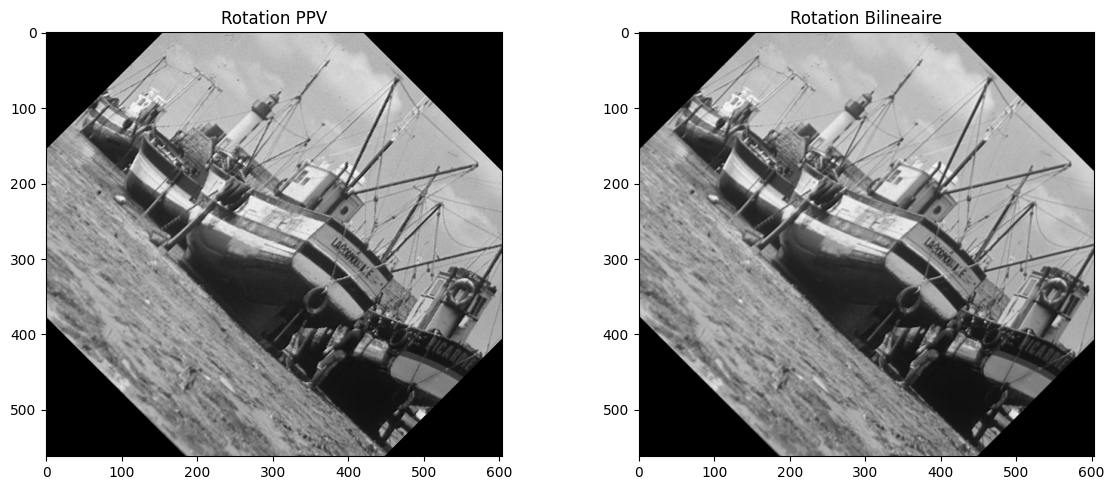

temps pour ppv :  0.1780085563659668
temps pour bi-lineaire :  0.7070701122283936


In [3]:
im = skio.imread('images/bat.tif')
plt.figure(figsize=(12,5))

plt.subplot(121)
start_time_ppv= time.time()
im_rotation_ppv = rotation(im,theta = 45,alpha = 1.0 , ech = 0 ) 
end_time_ppv = time.time()
plt.title('Rotation PPV')
plt.imshow(im_rotation_ppv,cmap='gray')

plt.subplot(122)
start_time_bi= time.time()
im_rotation_bi = rotation(im,theta=45 , alpha =1.0 ,ech =1)
end_time_bi = time.time()
plt.title('Rotation Bilineaire')
plt.imshow(im_rotation_bi,cmap='gray')

plt.tight_layout()
plt.show()

print('temps pour ppv : ' , end_time_ppv-start_time_ppv)
print('temps pour bi-lineaire : ' , end_time_bi-start_time_bi)


Concernant l'interpolation par la méthode du plus proche voisin (PPV), on suppose que l'image source est constante par morceaux et caractérisée par une certaine régularité. On attribue la valeur du pixel au nouveau point en considérant le point le plus proche.

En revanche, pour l'interpolation par la méthode bilinéaire, on considère que l'image source est linéaire par morceaux et on effectue l'interpolation selon les deux axes (x et y). 
> On peut observer une différence au niveau du temps d'exécution : la méthode bilinéaire est plus lente que la méthode PPV.

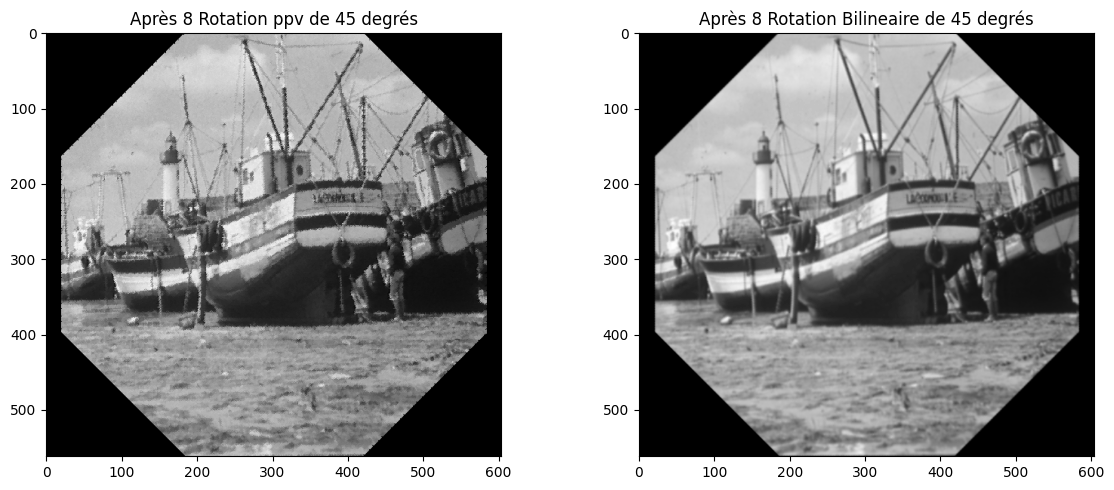

In [4]:
im_rotation_ppv = rotation(im,theta = 45,alpha = 1.0 , ech = 0 )
im_rotation_bi = rotation(im,theta = 45,alpha = 1.0 , ech = 1 ) 

for i in range(7):
    im_rotation_ppv = rotation(im_rotation_ppv,theta = 45,alpha = 1.0 , ech = 0) 
    im_rotation_bi = rotation(im_rotation_bi,theta = 45,alpha = 1.0 , ech = 1) 
    
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.title('Après 8 Rotation ppv de 45 degrés')
plt.imshow(im_rotation_ppv,cmap='gray')

plt.subplot(122)
plt.title('Après 8 Rotation Bilineaire de 45 degrés')
plt.imshow(im_rotation_bi,cmap='gray')

plt.tight_layout()
plt.show()

Lorsque l'on effectue 8 rotations successives de 45 degrés, l'image revient à sa position initiale. Cependant, on remarque une différence de qualité entre les deux méthodes d'interpolation. 

Dans le cas de la méthode PPV, on observe la présence d'aliasing : les contours deviennent crénelés et l'image perd en qualité. Avec la méthode bilinéaire, l'image est plus floue par rapport à l'original, mais les bords et les contours sont mieux préservés. 

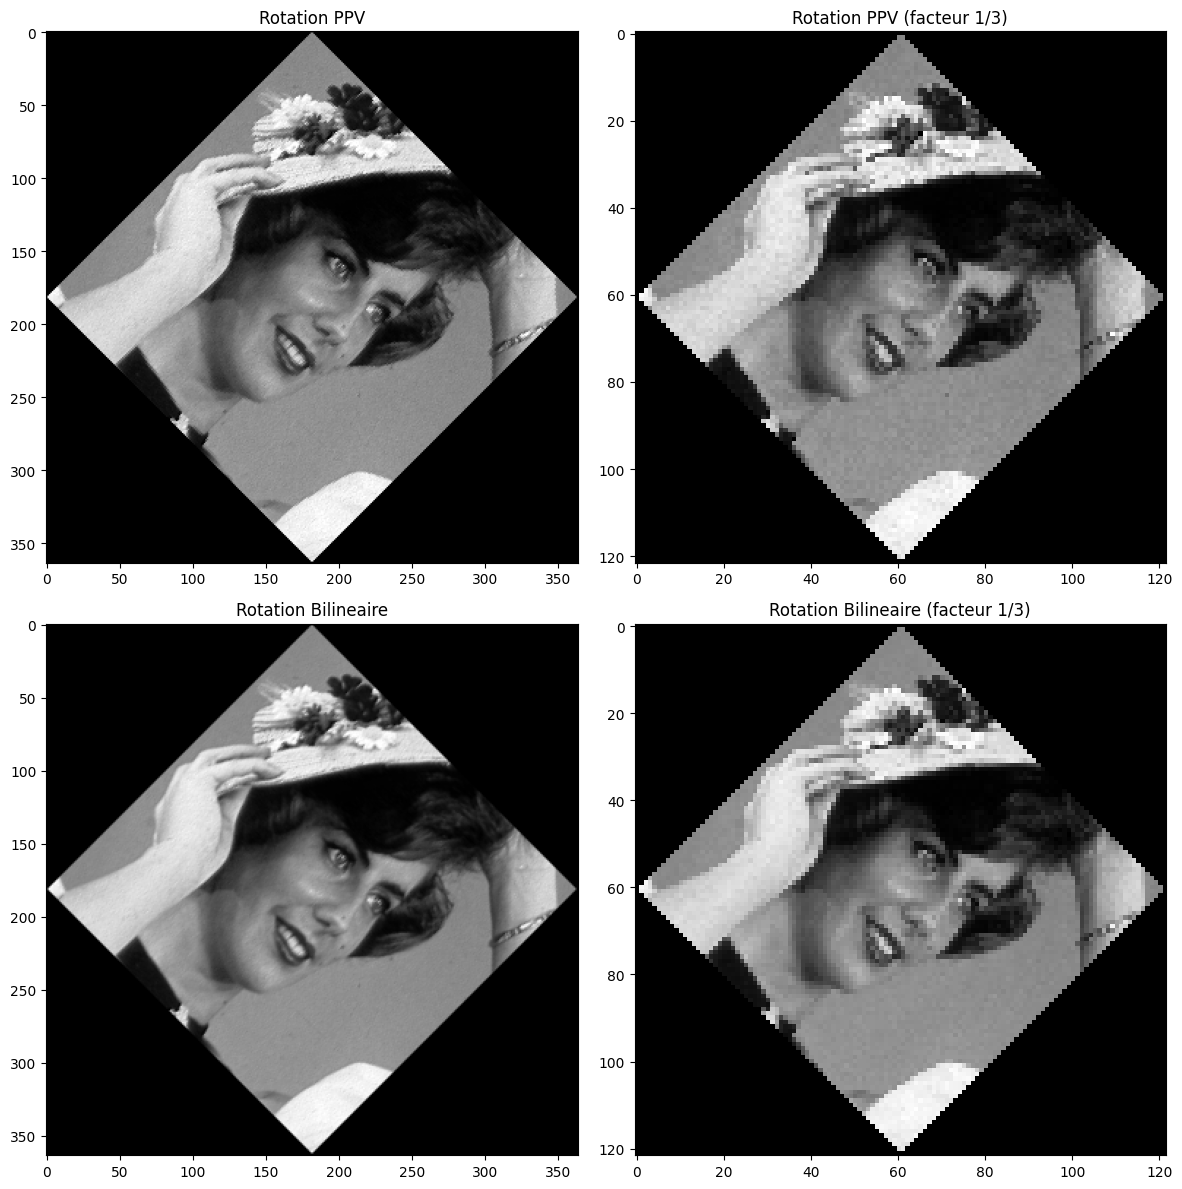

In [5]:
im = skio.imread('images/femme.tif')
plt.figure(figsize=(12,12))

plt.subplot(221)
im_rotation_ppv = rotation(im,theta = 45,alpha = 1.0 , ech = 0 , clip=False ) 
plt.title('Rotation PPV')
plt.imshow(im_rotation_ppv,cmap='gray')

plt.subplot(223)
im_rotation_bi = rotation(im,theta=45 , alpha =1.0 ,ech =1, clip=False)
plt.title('Rotation Bilineaire')
plt.imshow(im_rotation_bi,cmap='gray')

plt.subplot(222)
im_rotation_ppv = rotation(im,theta = 45,alpha = 1/3 , ech = 0, clip=False ) 
plt.title('Rotation PPV (facteur 1/3)')
plt.imshow(im_rotation_ppv,cmap='gray')

plt.subplot(224)
im_rotation_bi = rotation(im,theta=45 , alpha =1/3 ,ech =1, clip=False)
plt.title('Rotation Bilineaire (facteur 1/3)')
plt.imshow(im_rotation_bi,cmap='gray')

plt.tight_layout()
plt.show()


L'application d'un facteur de zoom inférieur à 1 (par exemple 1/3) lors de la rotation entraîne une dégradation de la qualité de l'image, qui devient pixellisée, comme un effet de mosaïque. Cela est dû au fait qu'un pixel de l'image finale représente une région plus grande de l'image originale, ce qui implique une perte d'information. 
> **Solution:** Pour atténuer cet effet, il est nécessaire d'appliquer un filtre passe-bas avant d'effectuer le dézoom, afin d'éliminer les hautes fréquences de l'image initiale. 
> **L'application d'un filtre passe-bas avant le dézoom permet d'obtenir une image plus lisse.**

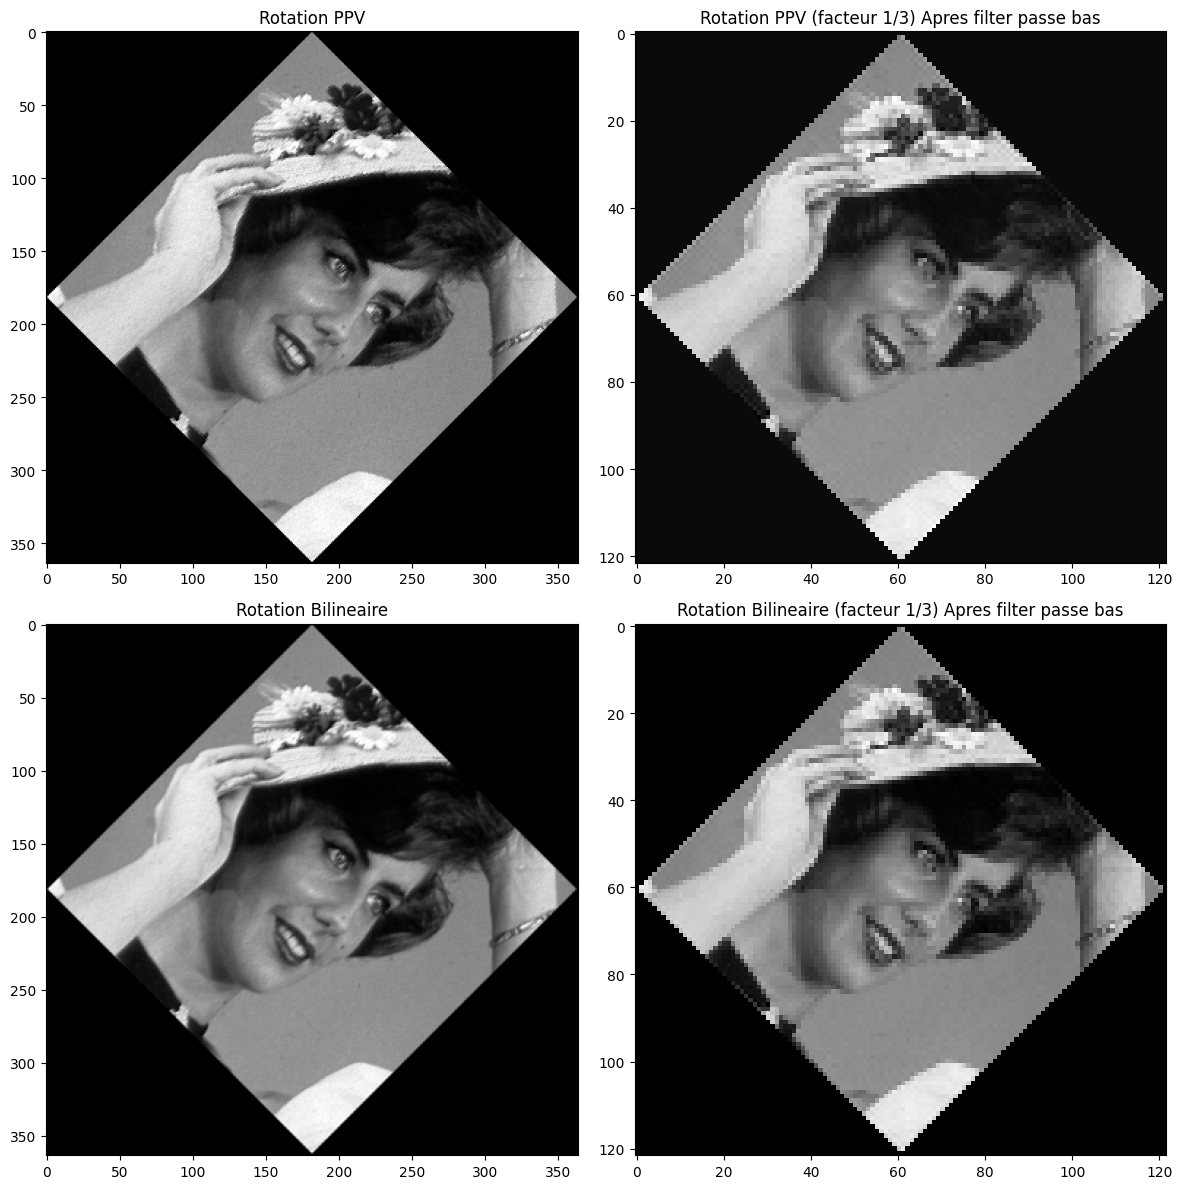

In [6]:
im = skio.imread('images/femme.tif')
plt.figure(figsize=(12,12))

plt.subplot(221)

im_rotation_ppv = rotation((im),theta = 45,alpha = 1.0 , ech = 0 , clip=False ) 
plt.title('Rotation PPV')
plt.imshow(im_rotation_ppv,cmap='gray')

plt.subplot(223)
im_rotation_bi = rotation((im),theta=45 , alpha =1.0 ,ech =1, clip=False)
plt.title('Rotation Bilineaire')
plt.imshow(im_rotation_bi,cmap='gray')

plt.subplot(222)
im_rotation_ppv = rotation(filterlow(im),theta = 45,alpha = 1/3 , ech = 0, clip=False ) 
plt.title('Rotation PPV (facteur 1/3) Apres filter passe bas')
plt.imshow(im_rotation_ppv,cmap='gray')

plt.subplot(224)
im_rotation_bi = rotation(filterlow(im),theta=45 , alpha =1/3 ,ech =1, clip=False)
plt.title('Rotation Bilineaire (facteur 1/3) Apres filter passe bas')
plt.imshow(im_rotation_bi,cmap='gray')

plt.tight_layout()
plt.show()


> Il est clair que l'image avec le filtre passe bas est plus lisse 

# 3. Filtrage linéaire et  médian

In [7]:
help(get_gau_ker)

Help on function get_gau_ker in module __main__:

get_gau_ker(s)



In [8]:
gau_ker = get_gau_ker(0.3)
gau_ker.shape

(3, 3)

In [9]:
gau_ker = get_gau_ker(0.7)
gau_ker.shape

(5, 5)

**Plus le paramètre "s" de la fonction get_gau_ker est grand, plus l'étalement est important et plus on capture d'informations. La taille du noyau est donc proportionnelle à ce paramètre.**

In [10]:
cst_ker = get_cst_ker(3)
cst_ker

array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]])

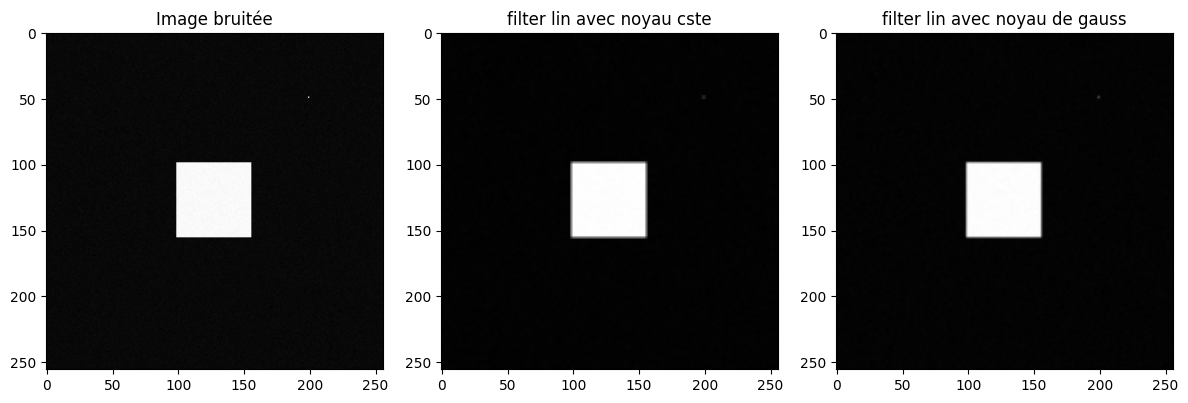

In [11]:
im = skio.imread('images/carre_orig.tif')

plt.figure(figsize=(12,8))

im_bruit = noise(im,2)

plt.subplot(131)
plt.title('Image bruitée')
plt.imshow(im_bruit,cmap='gray')

plt.subplot(132)
plt.title('filter lin avec noyau cste')
plt.imshow(filtre_lineaire(im_bruit,cst_ker),cmap='gray')

plt.subplot(133)
plt.title('filter lin avec noyau de gauss')
plt.imshow(filtre_lineaire(im_bruit,gau_ker),cmap='gray')


plt.tight_layout()
plt.show()

**On peut évaluer la quantité de bruit résiduel sur des images simples en calculant la variance dans une région homogène.**

In [12]:
help(var_image)

Help on function var_image in module __main__:

var_image(im, x0, y0, x1, y1)



In [13]:
print(var_image(im_bruit,100,100,150,150))
print(var_image(filtre_lineaire(im_bruit,cst_ker),100,100,150,150))
print(var_image(filtre_lineaire(im_bruit,gau_ker),100,100,150,150))


3.9516396502137163
0.432128352002313
0.9268378685042795


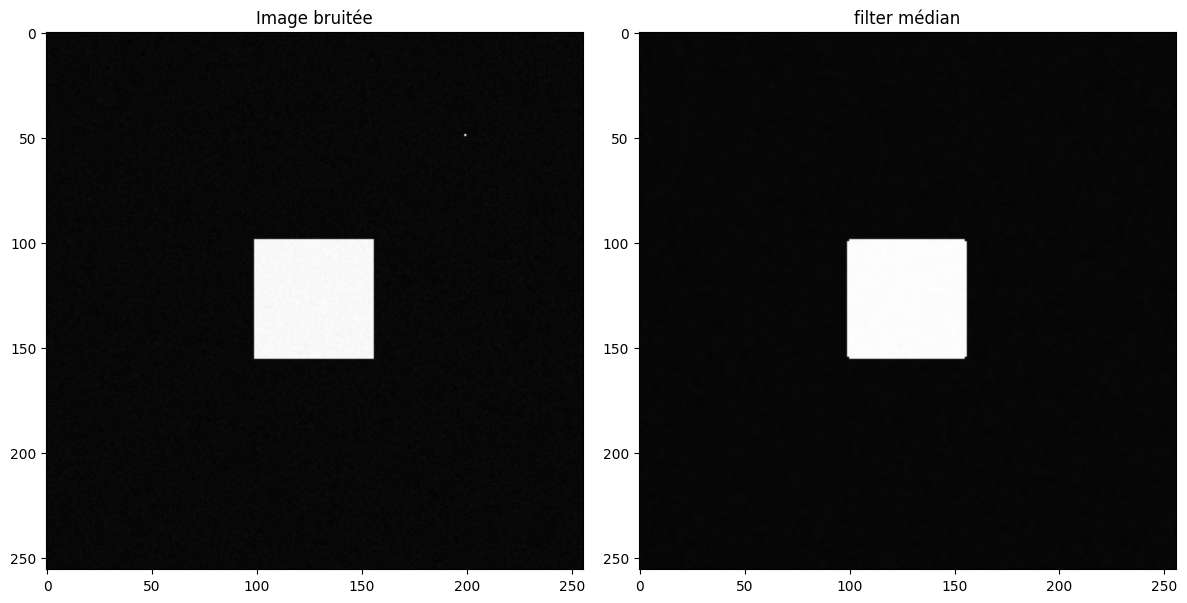

In [14]:
im = skio.imread('images/carre_orig.tif')

plt.figure(figsize=(12,8))

im_bruit = noise(im,2)

plt.subplot(121)
plt.title('Image bruitée')
plt.imshow(im_bruit,cmap='gray')

plt.subplot(122)
plt.title('filter médian')
plt.imshow(median_filter(im_bruit),cmap='gray')



plt.tight_layout()
plt.show()

In [15]:
print(var_image(im_bruit,100,100,150,150))
print(var_image(median_filter(im_bruit),100,100,150,150))

4.050174342091693
0.6295442398256632


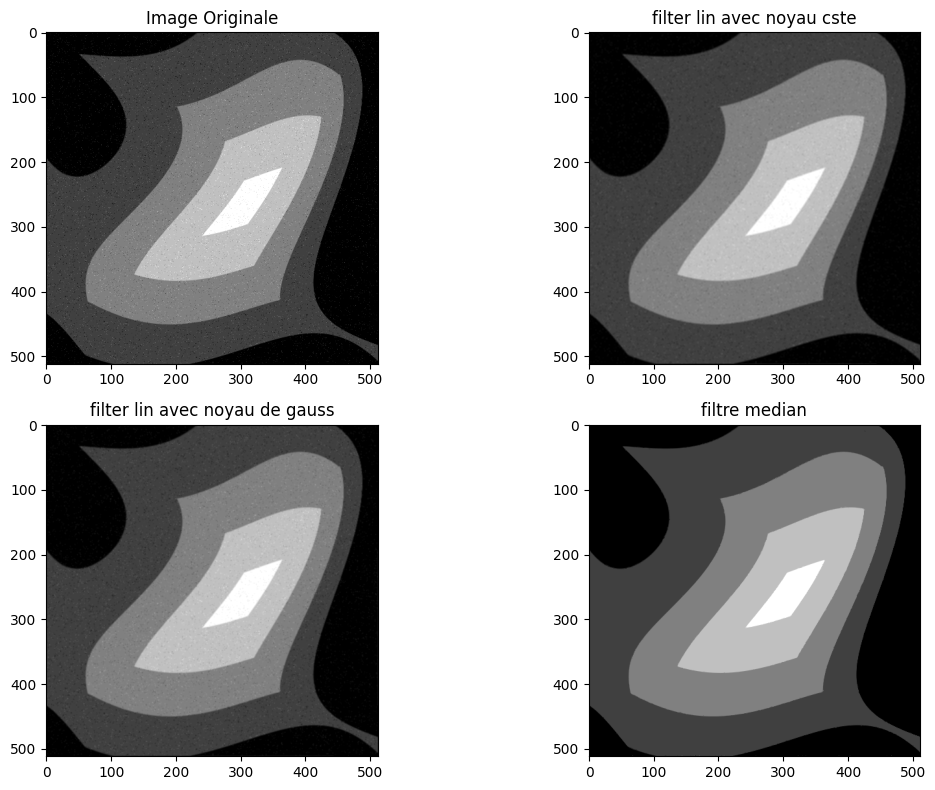

In [16]:
im_bruit = skio.imread('images/pyra-impulse.tif')

plt.figure(figsize=(12,8))

plt.subplot(221)
plt.title('Image Originale')
plt.imshow(im_bruit,cmap='gray')

plt.subplot(222)
plt.title('filter lin avec noyau cste')
plt.imshow(filtre_lineaire(im_bruit,cst_ker),cmap='gray')

plt.subplot(223)
plt.title('filter lin avec noyau de gauss')
plt.imshow(filtre_lineaire(im_bruit,gau_ker),cmap='gray')

plt.subplot(224)
plt.title('filtre median')
plt.imshow(median_filter(im_bruit),cmap='gray')


plt.tight_layout()
plt.show()

pour evaluer le débruitage d'un bruit dans ce type d'image on peut regarder les zones
constante dans l'image original. Ces zones doivent avoir une variance nulle car ils sont
constante. donc on evalue la variance de ces zones la dans l'image apres débruitage. Et
donc plus la variance est petit plus le débruitage est bon.
> **Le filtrage médian est particulièrement efficace pour supprimer le bruit impulsionnel, comme on peut le constater sur l'image pyra-impulse.tif.**

# 4. Restauration

In [17]:
help(filtre_inverse)

Help on function filtre_inverse in module __main__:

filtre_inverse(im, mask)
    renvoie l'inverse de mask applique a im.



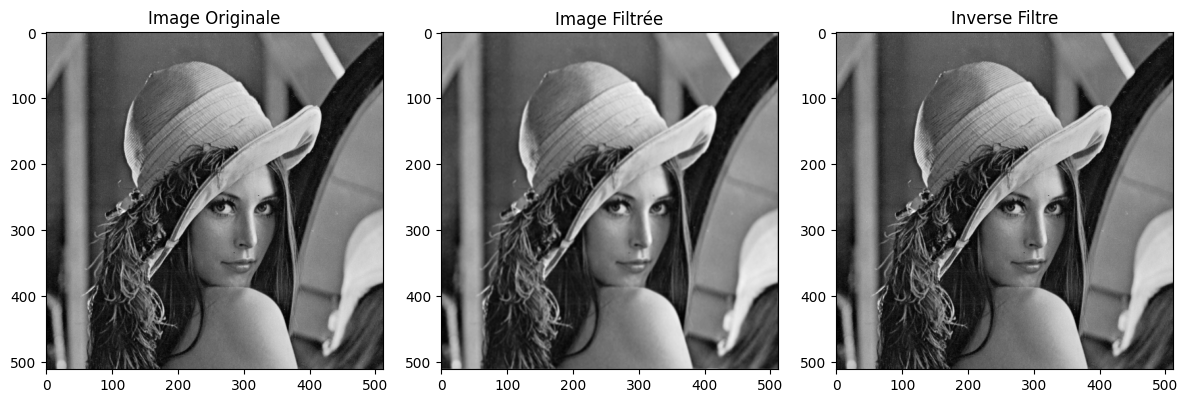

In [18]:
plt.figure(figsize=(12,8))

im = skio.imread("images/lena.tif")

mask = get_cst_ker(3)

plt.subplot(131)
plt.title('Image Originale')
plt.imshow(im,cmap='gray')

plt.subplot(132)
plt.title('Image Filtrée')
im_filtre = filtre_lineaire(im,mask) # j'ai utilisé le noyau cste
plt.imshow(im_filtre,cmap='gray')

plt.subplot(133)
plt.title('Inverse Filtre')
im_inverse_filtre = filtre_inverse(im_filtre,mask)
plt.imshow(im_inverse_filtre,cmap='gray')

plt.tight_layout()
plt.show()

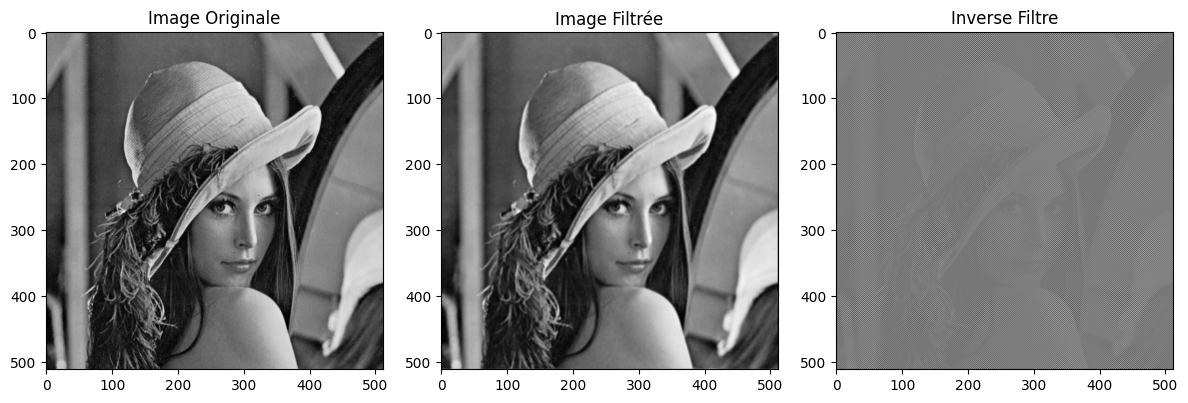

In [19]:
plt.figure(figsize=(12,8))

im = skio.imread("images/lena.tif")

mask = get_cst_ker(3)

plt.subplot(131)
plt.title('Image Originale')
plt.imshow(im,cmap='gray')

plt.subplot(132)
plt.title('Image Filtrée')
im_filtre = filtre_lineaire(im,mask) # j'ai utilisé le noyau cste
plt.imshow(im_filtre,cmap='gray')

im_filtre_bruit = noise(im_filtre,0.5)

plt.subplot(133)
plt.title('Inverse Filtre')
im_inverse_filtre = filtre_inverse(im_filtre_bruit,mask)
plt.imshow(im_inverse_filtre,cmap='gray')

plt.tight_layout()
plt.show()

**L'application d'un filtre inverse après un filtrage linéaire permet en théorie de retrouver l'image originale. Cependant, en présence de bruit, le filtre inverse amplifie le bruit, ce qui rend l'image restaurée inexploitable.**

**Pour déterminer le noyau de convolution qu'a subi l'image carre_flou.tif, on peut diviser la transformée de Fourier de l'image floue par la transformée de Fourier de l'image originale.**

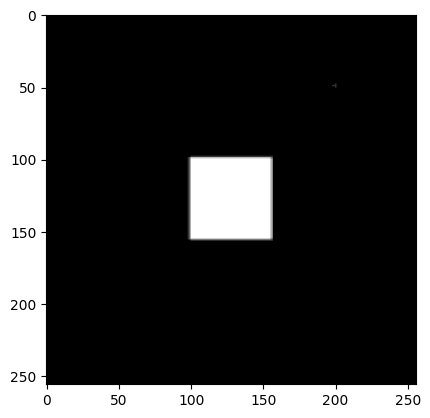

In [20]:
im_flou = skio.imread('images/carre_flou.tif')
im = skio.imread('images/carre_orig.tif')


plt.imshow(im_flou, cmap ='gray') 

In [21]:
transforme_fourier_im=np.fft.fft2(im)
transforme_fourier_im_flou=np.fft.fft2(im_flou)

mask = np.fft.fftshift(np.fft.ifft2(transforme_fourier_im_flou / (transforme_fourier_im + 1e-8)))
mask

array([[-1.83105465e-05-1.14367939e-17j,  6.10351585e-06-5.73683960e-18j,
         1.83105467e-05+1.62639836e-17j, ...,
        -1.83105472e-05+1.38053586e-17j,  1.83105464e-05-5.60349385e-18j,
        -1.83105469e-05-1.00399580e-17j],
       [ 1.22070308e-05+1.64588792e-17j, -1.22070315e-05-1.44641553e-18j,
         3.44325421e-13-1.34618096e-17j, ...,
         1.22070316e-05-1.35367743e-17j,  3.18311128e-13+2.21517647e-18j,
         1.22070311e-05+1.01476719e-17j],
       [-6.10351515e-06-1.19196258e-17j,  1.83105471e-05+5.47357361e-18j,
        -1.83105472e-05+1.69926635e-17j, ...,
        -6.10351606e-06+1.92386624e-17j, -1.83105471e-05-8.65396731e-18j,
        -6.10351535e-06-1.52841017e-17j],
       ...,
       [ 1.22070311e-05+2.73331938e-17j, -1.22070317e-05+1.84494959e-17j,
        -1.91822153e-13+8.88186171e-18j, ...,
         1.22070314e-05-1.41286137e-17j,  3.69781921e-13+5.35296695e-19j,
         1.22070314e-05+1.15002716e-17j],
       [-6.10351537e-06-2.68697188e-17j,  1.

C:\Users\MSI\AppData\Local\Temp\ipykernel_6564\667164328.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  KK[:yK,:xK]=K


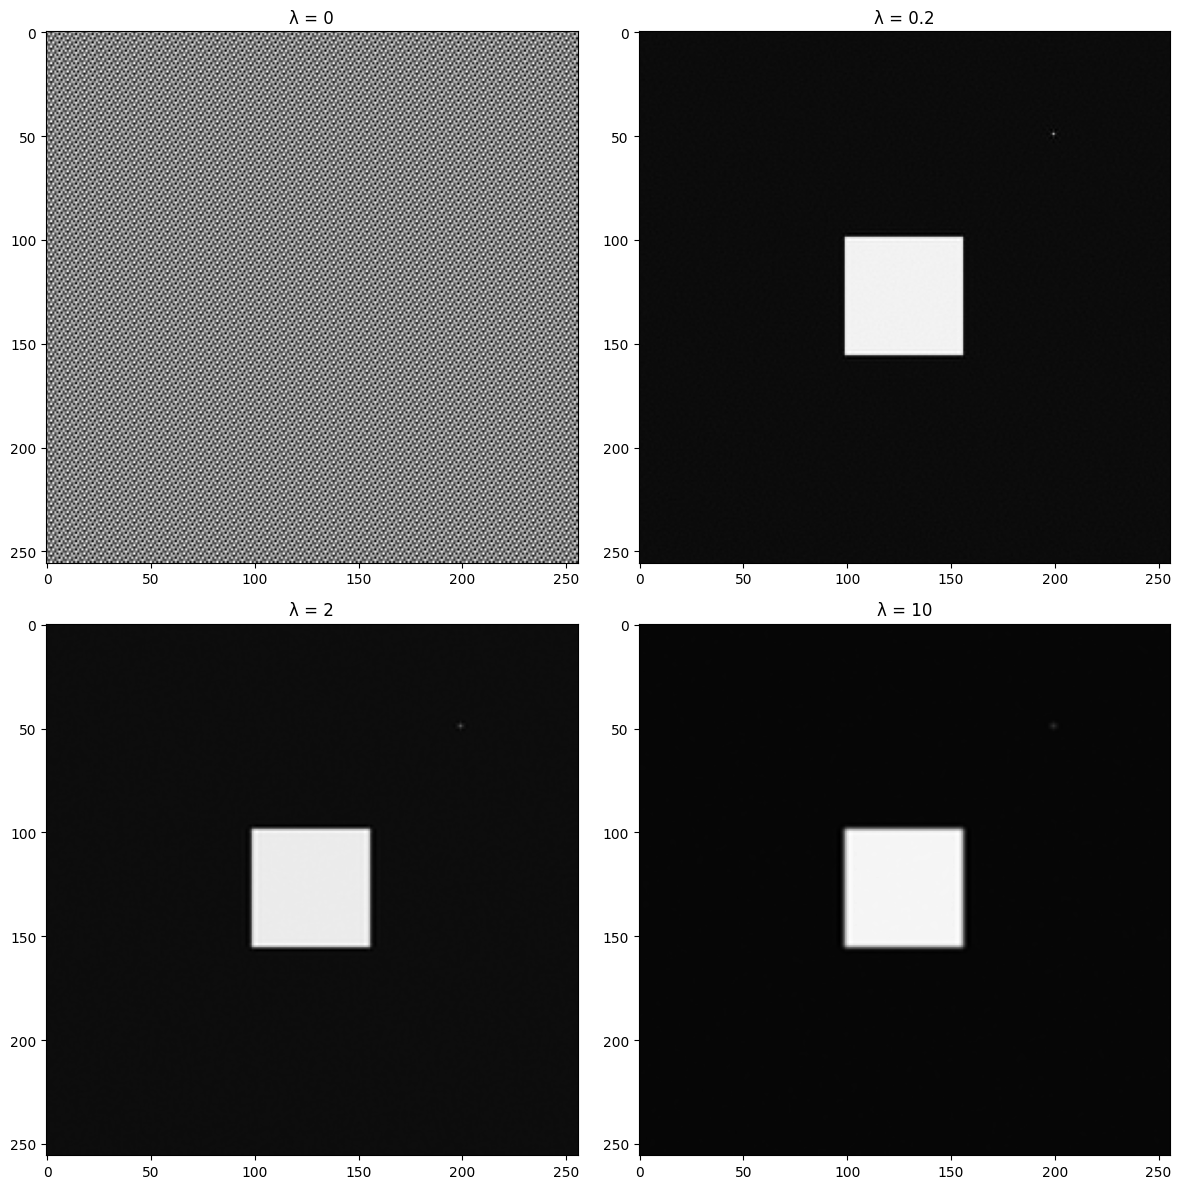

In [22]:
im_flou_bruit = noise(im_flou,0.5)

plt.figure(figsize =(12,12))

plt.subplot(221)
im_wiener = wiener(im_flou_bruit,mask,lamb=0)
plt.title('λ = 0')
plt.imshow(im_wiener,cmap='gray')

plt.subplot(222)
im_wiener = wiener(im_flou_bruit,mask,lamb=0.2)
plt.title('λ = 0.2')
plt.imshow(im_wiener,cmap='gray')

plt.subplot(223)
im_wiener = wiener(im_flou_bruit,mask,lamb=2)
plt.title('λ = 2')
plt.imshow(im_wiener,cmap='gray')

plt.subplot(224)
im_wiener = wiener(im_flou_bruit,mask,lamb=10)
plt.title('λ = 10')
plt.imshow(im_wiener,cmap='gray')


plt.tight_layout()
plt.show()

L'application d'un filtre inverse sans régularisation peut amplifier le bruit, surtout si l'image est légèrement bruitée avant la restauration. Le filtrage de Wiener, qui inclut un terme de régularisation dépendant du bruit, permet de contrôler cette amplification du bruit. En ajustant le paramètre λ, on peut trouver un équilibre entre la restauration des détails de l'image et la suppression du bruit.

> **Le filtrage de Wiener permet de restaurer une image bruitée en tenant compte du flou et du bruit. Le paramètre "λ" contrôle l'importance de la régularisation.**

# 5. Applications

## 5.1 Comparaison filtrage linéaire et médian

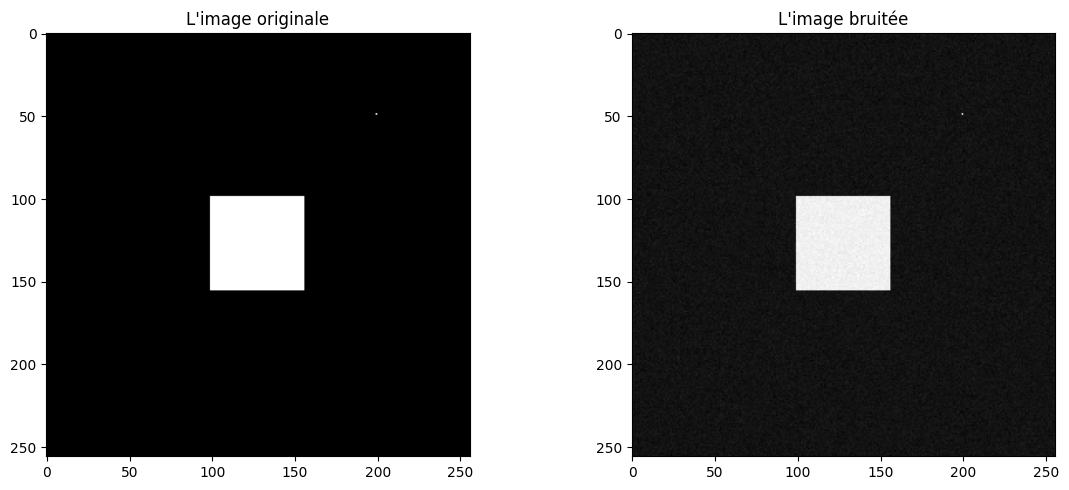

In [23]:
im = skio.imread('images/carre_orig.tif')
plt.figure(figsize=(12,5))


plt.subplot(121)
plt.imshow(im,cmap='gray')
plt.title('L\'image originale')

plt.subplot(122)
im_bruit = noise(im,5)
plt.imshow(im_bruit,cmap='gray')
plt.title('L\'image bruitée')

plt.tight_layout()
plt.show()

In [24]:
help(median_filter)

Help on function median_filter in module __main__:

median_filter(im, typ=1, r=1, xy=None)
    renvoie le median de l'image im.
    si typ==1 (defaut) le median est calcule sur un carre de cote 2r+1
    si typ==2 : disque de rayon r
    si typ==3 alors xy est un couple de liste de x et liste de y
         ([-1,0,1] , [0,0,0]) donne un median sur un segment horizontql de taille trois.



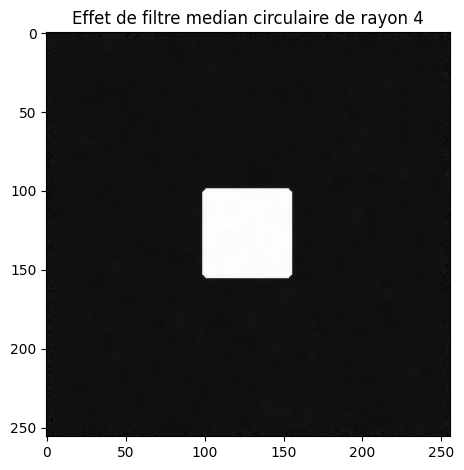

In [25]:
plt.title('Effet de filtre median circulaire de rayon 4')
plt.imshow(median_filter(im_bruit,typ=2,r=4),cmap='gray')

plt.tight_layout()
plt.show()

In [26]:
var_bruit = var_image(im,100,100,150,150)
var_median_filter = var_image(median_filter(im_bruit, typ=2, r=4),100,100,150,150)


print(f"VAR (avec bruit): {var_bruit:.4f}")
print(f"VAR (avec filter median): {var_median_filter:.4f}")

VAR (avec bruit): 0.0000
VAR (avec filter median): 1.0702


In [27]:
%%time

taille = 1
while True:
    if taille > im.shape[0]:
        taille-=2
        break
    mask= get_cst_ker(taille)
    var_lineaire = var_image(filtre_lineaire(im_bruit,mask),100,100,150,150)
    if var_lineaire<=var_median_filter :
        break
    taille+=2
    

print(f"La taille du noyau constant équivalent est : {taille}x{taille}")

La taille du noyau constant équivalent est : 105x105
CPU times: total: 359 ms
Wall time: 366 ms


In [28]:
var_lineaire

0.9030426247941898

Explication de l'algorithme :

Vous calculez d'abord la variance du bruit dans une région spécifique de l'image (100-150 x 100-150).
Ensuite, vous appliquez un filtre médian circulaire de rayon 4 et calculez la variance dans la même région.
Vous commencez une boucle avec un filtre linéaire (moyenneur) de taille croissante :
>a. Vous créez un noyau constant de taille croissante.
>
>b. Vous appliquez ce filtre linéaire à l'image bruitée.
>
>c. Vous calculez la variance dans la même région.
>
>d. Vous comparez cette variance à celle obtenue avec le filtre médian.
>
>e. Vous augmentez la taille du noyau de 2 à chaque itération jusqu'à ce que la variance soit inférieure ou égale à celle du filtre médian.
>
>La boucle s'arrête quand vous trouvez un filtre linéaire qui réduit le bruit autant ou plus que le filtre médian.

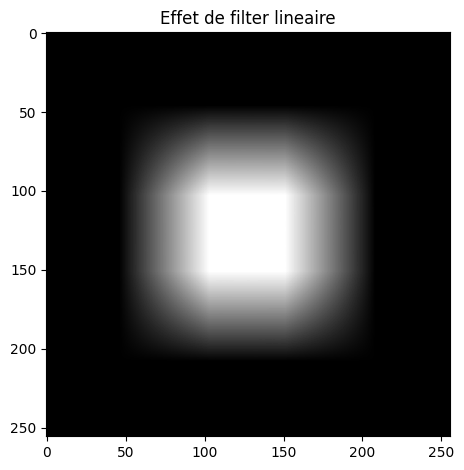

In [29]:
mask = get_cst_ker(taille)
plt.title('Effet de filter lineaire')
plt.imshow(filtre_lineaire(im_bruit,mask),cmap='gray')


plt.tight_layout()
plt.show()

Le résultat montre qu'un filtre linéaire (moyenneur) avec un noyau constant de taille 107x107 réduit le bruit dans les mêmes proportions qu'un filtre médian circulaire de rayon 4.

* **Ce résultat est intéressant car il montre que :**

    - Le filtre médian est très efficace pour réduire le bruit tout en préservant les bords, car il nécessite une fenêtre beaucoup plus petite (9x9 pour un rayon de 4) que le filtre linéaire équivalent (107x107).
    - Pour obtenir une réduction de bruit similaire avec un filtre linéaire, il faut utiliser une fenêtre beaucoup plus grande, ce qui risque de flouter davantage l'image, en particulier les détails fins et les bords.
    - Le filtre médian est probablement plus efficace en termes de préservation des détails de l'image tout en réduisant le bruit.

## 5.2 Calcul théorique du paramètre de restauration

En modifiant la fonction Wiener pour prendre en compte la densité spectrale de l'image dégradée plutôt que d'utiliser une approximation constante, on peut potentiellement améliorer la restauration en ajustant le filtre spécifiquement aux caractéristiques de l'image et du bruit observés.

In [30]:
def wiener2(im,K,var=1):
    """effectue un filtrage de wiener de l'image im par le filtre K.
       lamb=0 donne le filtre inverse
       on rappelle que le filtre de Wiener est une tentaive d'inversion du noyau K
       avec une regularisation qui permet de ne pas trop augmenter le bruit.
       """
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    (ty,tx)=im.shape
    (yK,xK)=K.shape
    KK=np.zeros((ty,tx))
    KK[:yK,:xK]=K
    x2=tx/2
    y2=ty/2
    
    fX=np.concatenate((np.arange(0,x2+0.99),np.arange(-x2+1,-0.1)))
    fY=np.concatenate((np.arange(0,y2+0.99),np.arange(-y2+1,-0.1)))
    fX=np.ones((ty,1))@fX.reshape((1,-1))
    fY=fY.reshape((-1,1))@np.ones((1,tx))
    fX=fX/tx
    fY=fY/ty
    
    w2=fX**2+fY**2
    w=w2**0.5
    
    #tranformee de Fourier de l'image degradeee
    g=fft2(im)
    #transformee de Fourier du noyau
    k=fft2(KK)
    #nouveau quotien introduit 
    quotient = ( ty*tx * var) /(g**2)
    #fonction de mutilplication
    mul=np.conj(k)/(abs(k)**2+quotient)
    #filtrage de wiener
    fout=g*mul
    
    # on effectue une translation pour une raison technique
    mm=np.zeros((ty,tx))
    y2=int(np.round(yK/2-0.5))
    x2=int(np.round(xK/2-0.5))
    mm[y2,x2]=1
    out=np.real(ifft2(fout*(fft2(mm))))
    return out


In [31]:
im2=skio.imread("images/carre_flou.tif")
noisy_square = noise(im2,5)
result= wiener2(noisy_square,mask,5)

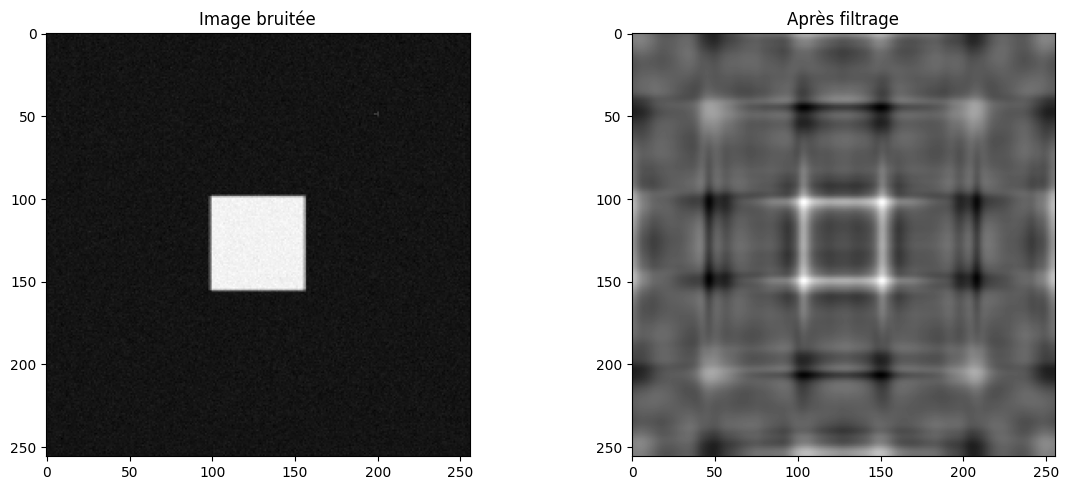

In [32]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(noisy_square,cmap='gray')
plt.title('Image bruitée')

plt.subplot(122)
plt.imshow(result,cmap='gray')
plt.title('Après filtrage')


plt.tight_layout()
plt.show()